In [ ]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import os
from os.path import isfile, join
from os import listdir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DataSet

In [ ]:
path_round = "/content/drive/MyDrive/flatlay_images_neckline/round"
path_scoop = "/content/drive/MyDrive/flatlay_images_neckline/scoop"
path_vneck = "/content/drive/MyDrive/flatlay_images_neckline/v-neck"

onlyfiles = [ f for f in listdir(path_round) if isfile(join(path_round,f)) ]
round = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
    round[n] = cv2.imread( join(path_round,onlyfiles[n]) )

onlyfiles = [ f for f in listdir(path_scoop) if isfile(join(path_scoop,f)) ]
scoop = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
    scoop[n] = cv2.imread( join(path_scoop,onlyfiles[n]) )

onlyfiles = [ f for f in listdir(path_vneck) if isfile(join(path_vneck,f)) ]
vneck = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
    vneck[n] = cv2.imread( join(path_vneck,onlyfiles[n]) )

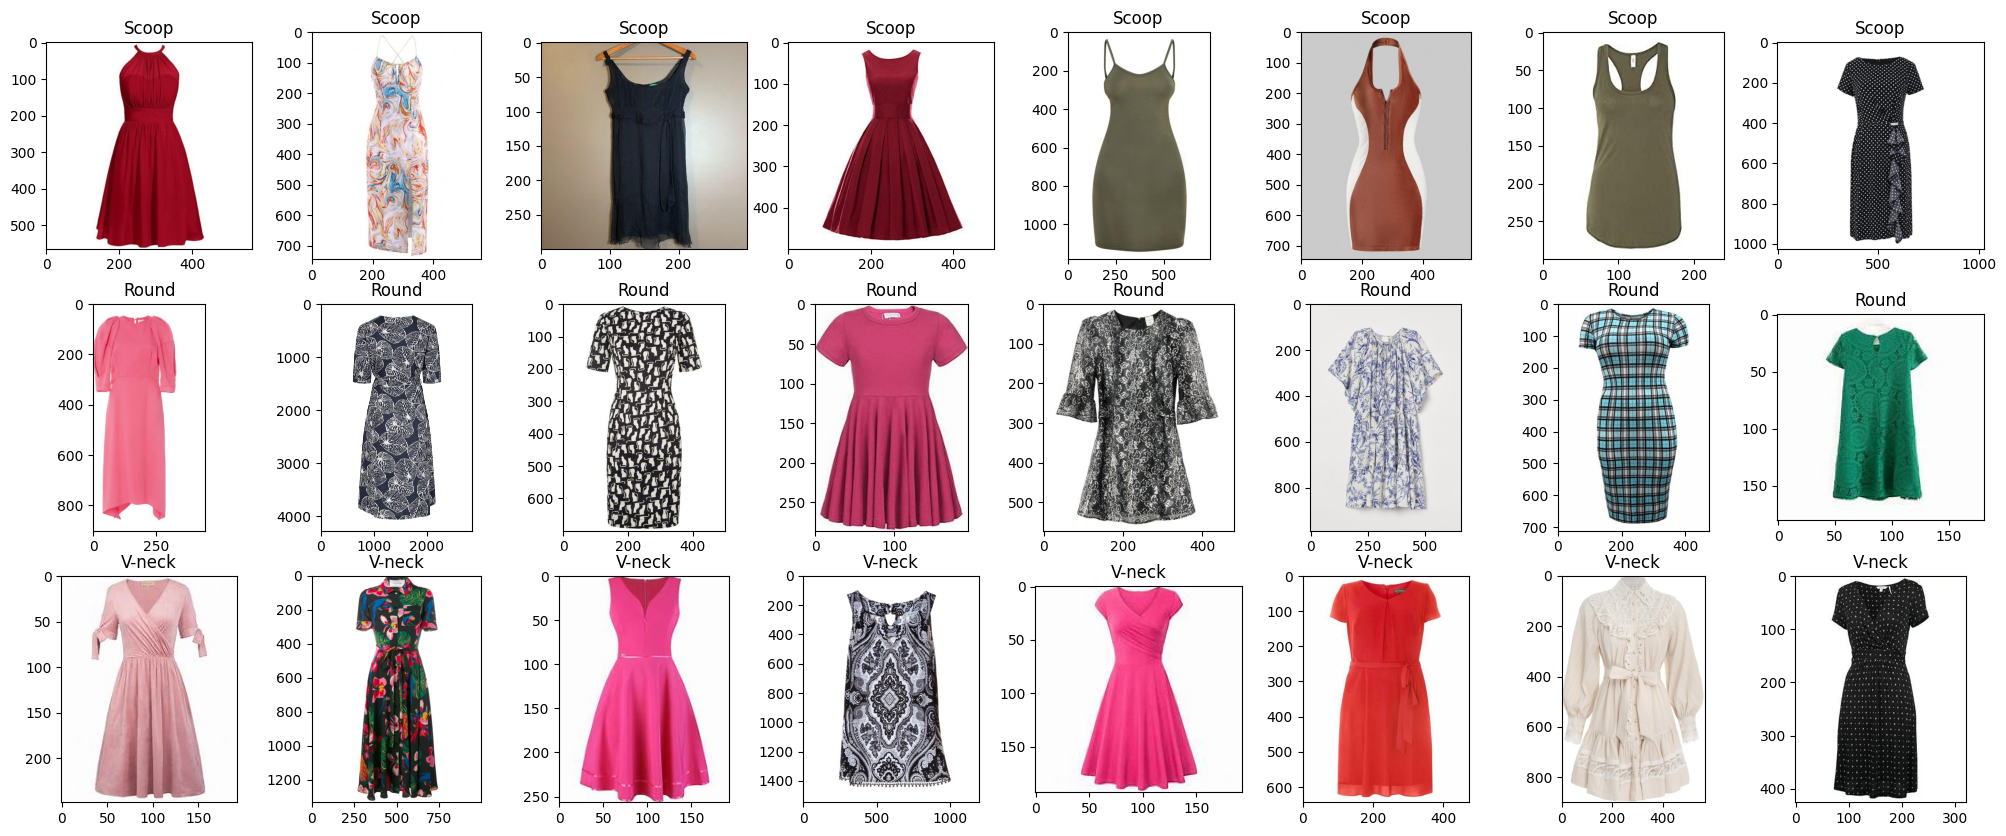

In [ ]:
fig, ax = plt.subplots(3,8, figsize=(25,10))

for i in range(3):
  if i == 0:
    for j in range(8):
      ax[i, j].imshow(cv2.cvtColor(scoop[j], cv2.COLOR_BGR2RGB))
      ax[i, j].set_title("Scoop", fontsize=12)
  if i == 1:
    for j in range(8):
      ax[i, j].imshow(cv2.cvtColor(round[j], cv2.COLOR_BGR2RGB))
      ax[i, j].set_title("Round", fontsize=12)
  if i == 2:
    for j in range(8):
      ax[i, j].imshow(cv2.cvtColor(vneck[j], cv2.COLOR_BGR2RGB))
      ax[i, j].set_title("V-neck", fontsize=12)

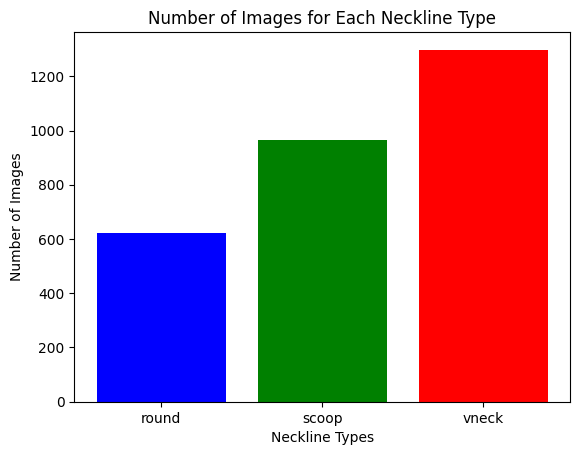

In [ ]:
scoop_s = scoop.shape[0]
round_s = round.shape[0]
vneck_s = vneck.shape[0]

plt.bar(["round", "scoop", "vneck"], [round_s, scoop_s, vneck_s], color=['blue', 'green', 'red'])
plt.xlabel('Neckline Types')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Neckline Type')

plt.show()

# VGG16 Model

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16


IMAGE_SIZE = [224, 224]


vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)


for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

x = Dense(3, activation = 'softmax')(x)

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

IMAGE_SIZE = [224, 224]

training_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input,
                                    validation_split=0.2
                                    )

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input, validation_split=0.2)

training_generator = training_datagen.flow_from_directory("/content/drive/MyDrive/cropped_resized_images", target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical',subset='training', shuffle=True)
validation_generator = validation_datagen.flow_from_directory("/content/drive/MyDrive/cropped_resized_images", target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical',subset='validation', shuffle=True)

num_classes = 3
class_labels = ["round", "scoop", "v-neck"]

num_images_per_class = [621, 966, 1298]
total_samples = sum(num_images_per_class)

class_weights = {}
for class_idx in range(num_classes):
    class_name = class_labels[class_idx]
    weight = total_samples / (num_classes * num_images_per_class[class_idx])
    class_weights[class_idx] = weight

Found 2309 images belonging to 3 classes.
Found 576 images belonging to 3 classes.


In [ ]:
history = model.fit_generator(training_generator,
                   steps_per_epoch = 20,
                   epochs = 10,
                   validation_data = validation_generator,
                   validation_steps = 8,
                   class_weight=class_weights
                   )

<ipython-input-7-bfe12322dac2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_generator,


Epoch 1/10
20/20 [==============================] - 1554s 78s/step - loss: 1.4786 - accuracy: 0.4539 - val_loss: 1.0295 - val_accuracy: 0.5293
Epoch 2/10
20/20 [==============================] - 304s 16s/step - loss: 0.8675 - accuracy: 0.6102 - val_loss: 0.9710 - val_accuracy: 0.5723
Epoch 3/10
20/20 [==============================] - 163s 8s/step - loss: 0.7553 - accuracy: 0.6708 - val_loss: 0.9656 - val_accuracy: 0.5996
Epoch 4/10
20/20 [==============================] - 81s 4s/step - loss: 0.6723 - accuracy: 0.7008 - val_loss: 0.7645 - val_accuracy: 0.6445
Epoch 5/10
20/20 [==============================] - 43s 2s/step - loss: 0.6159 - accuracy: 0.7461 - val_loss: 0.7551 - val_accuracy: 0.6699
Epoch 6/10
20/20 [==============================] - 33s 2s/step - loss: 0.5813 - accuracy: 0.7602 - val_loss: 0.7423 - val_accuracy: 0.6738
Epoch 7/10
20/20 [==============================] - 24s 1s/step - loss: 0.5895 - accuracy: 0.7682 - val_loss: 0.7491 - val_accuracy: 0.6777
Epoch 8/10
20/

In [ ]:
model.save('/content/drive/MyDrive/Neckline_model_classweight.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

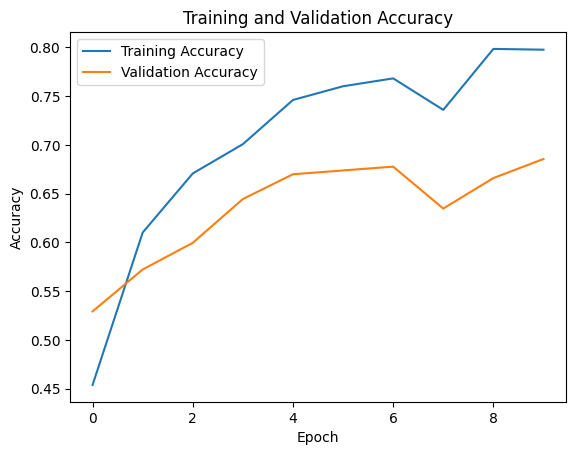

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

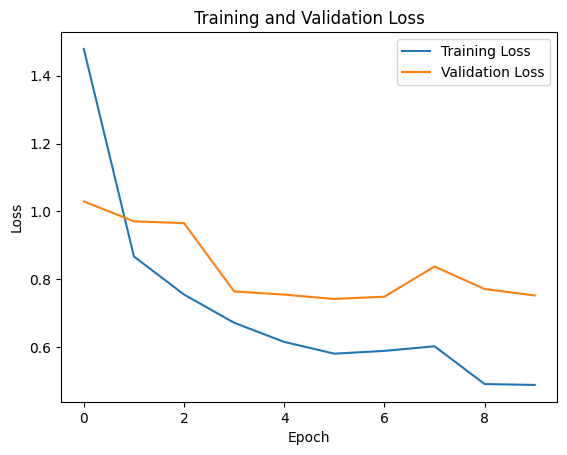

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualization

9/9 [==============================] - 8s 862ms/step


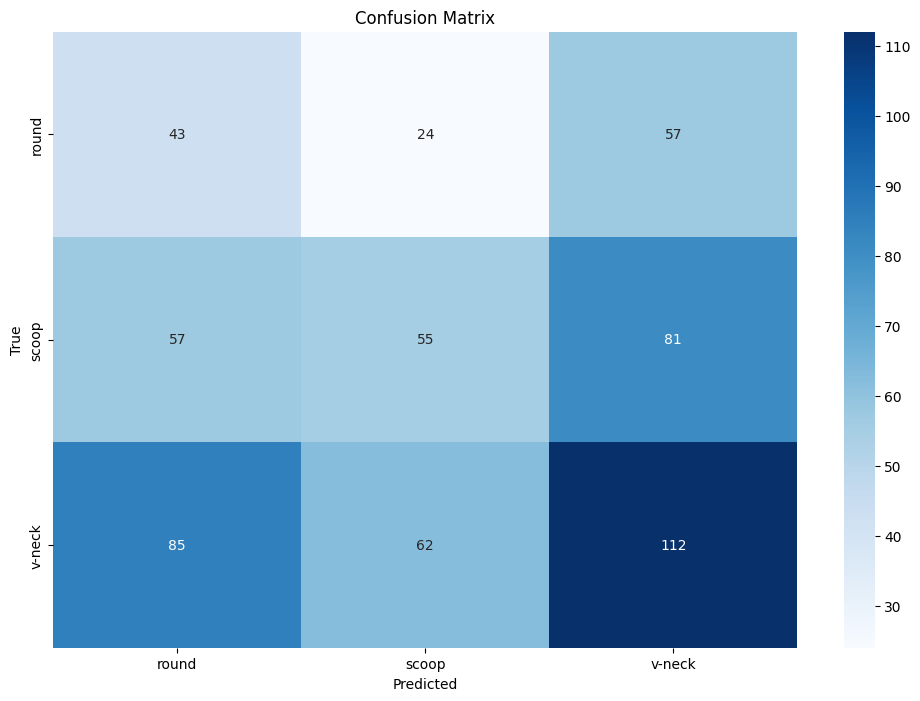

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = validation_generator.classes
y_pred_probabilities = model.predict(validation_generator)
y_pred = y_pred_probabilities.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Test

In [ ]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import os
from os.path import isfile, join
from os import listdir

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path1 = '/content/drive/MyDrive/laila_black_multiway_maxi_dress_flat_lay_2_mxp8oiepia.jpg'
img = image.load_img(img_path1, target_size=(224, 224))
img_array1 = image.img_to_array(img)
img_array1 = np.expand_dims(img_array1, axis=0)

1/1 [==============================] - 1s 1s/step
1: round - Probability: 0.0
2: scoop - Probability: 3.246793640813885e-33
3: v-neck - Probability: 1.0
Predicted Class: v-neck
Probability: 1.0


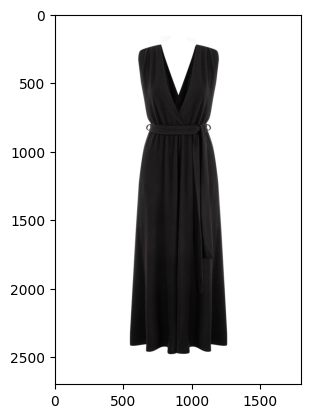

In [ ]:
image1 = cv2.imread(img_path1)
image_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb1)

predictions = model.predict(img_array1)
for i in range(3):
    print(f"{i + 1}: {class_labels[i]} - Probability: {predictions[0][i]}")
max_class_index = np.argmax(predictions)
max_class_label = class_labels[max_class_index]
max_probability = predictions[0][max_class_index]
print(f"Predicted Class: {max_class_label}")
print(f"Probability: {max_probability}")

# MobileNet

In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
model_mb = Sequential()
model_mb.add(base_model)
model_mb.add(GlobalAveragePooling2D())
model_mb.add(Dense(256, activation='relu'))
model_mb.add(Dense(3, activation='softmax'))


In [ ]:
model_mb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
history33 = model_mb.fit(training_generator,
                       steps_per_epoch=len(training_generator),
                       epochs=10,
                       validation_data=validation_generator,
                       validation_steps=len(validation_generator),
                       class_weight=class_weights
                                            )

Epoch 1/10
37/37 [==============================] - 58s 1s/step - loss: 1.1212 - accuracy: 0.6193 - val_loss: 2.9515 - val_accuracy: 0.3351
Epoch 2/10
37/37 [==============================] - 44s 1s/step - loss: 0.5308 - accuracy: 0.7804 - val_loss: 1.2391 - val_accuracy: 0.5677
Epoch 3/10
37/37 [==============================] - 43s 1s/step - loss: 0.4390 - accuracy: 0.8151 - val_loss: 0.7442 - val_accuracy: 0.7222
Epoch 4/10
37/37 [==============================] - 41s 1s/step - loss: 0.4359 - accuracy: 0.8142 - val_loss: 0.6786 - val_accuracy: 0.7118
Epoch 5/10
37/37 [==============================] - 42s 1s/step - loss: 0.3613 - accuracy: 0.8575 - val_loss: 1.0667 - val_accuracy: 0.6510
Epoch 6/10
37/37 [==============================] - 44s 1s/step - loss: 0.3152 - accuracy: 0.8748 - val_loss: 0.9073 - val_accuracy: 0.6858
Epoch 7/10
37/37 [==============================] - 43s 1s/step - loss: 0.3989 - accuracy: 0.8411 - val_loss: 2.0677 - val_accuracy: 0.5816
Epoch 8/10
37/37 [==

In [ ]:
model_mb.save('/content/drive/MyDrive/Neckline_MobileNet_classweight.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
training_accuracy = history33.history['accuracy']
validation_accuracy = history33.history['val_accuracy']

# Print the accuracy for each epoch
for epoch, (train_acc, val_acc) in enumerate(zip(training_accuracy, validation_accuracy), 1):
    print(f"Epoch {epoch}: Training Accuracy = {train_acc}, Validation Accuracy = {val_acc}")

Epoch 1: Training Accuracy = 0.6193157434463501, Validation Accuracy = 0.3350694477558136
Epoch 2: Training Accuracy = 0.7804244160652161, Validation Accuracy = 0.5677083134651184
Epoch 3: Training Accuracy = 0.8150714635848999, Validation Accuracy = 0.7222222089767456
Epoch 4: Training Accuracy = 0.8142052888870239, Validation Accuracy = 0.7118055820465088
Epoch 5: Training Accuracy = 0.8575140833854675, Validation Accuracy = 0.6510416865348816
Epoch 6: Training Accuracy = 0.8748375773429871, Validation Accuracy = 0.6857638955116272
Epoch 7: Training Accuracy = 0.841056764125824, Validation Accuracy = 0.5815972089767456
Epoch 8: Training Accuracy = 0.8440883755683899, Validation Accuracy = 0.6631944179534912
Epoch 9: Training Accuracy = 0.8518839478492737, Validation Accuracy = 0.6736111044883728
Epoch 10: Training Accuracy = 0.905153751373291, Validation Accuracy = 0.6545138955116272


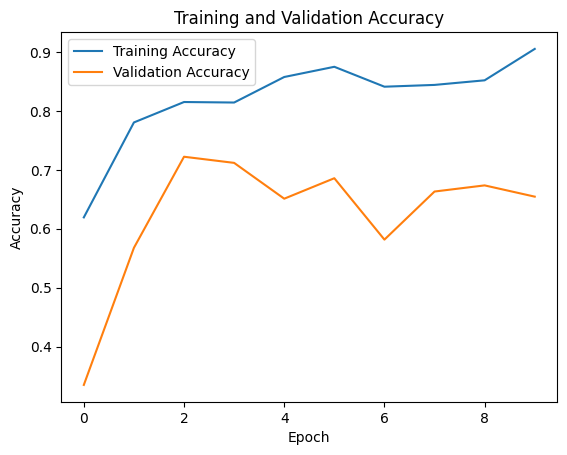

In [ ]:
plt.plot(history33.history['accuracy'], label='Training Accuracy')
plt.plot(history33.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

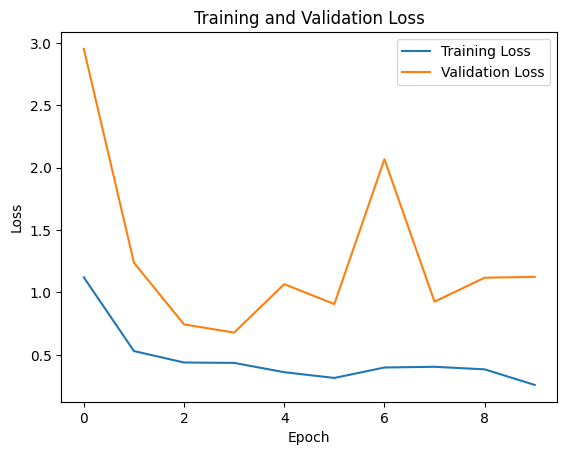

In [ ]:
plt.plot(history33.history['loss'], label='Training Loss')
plt.plot(history33.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 4s 323ms/step


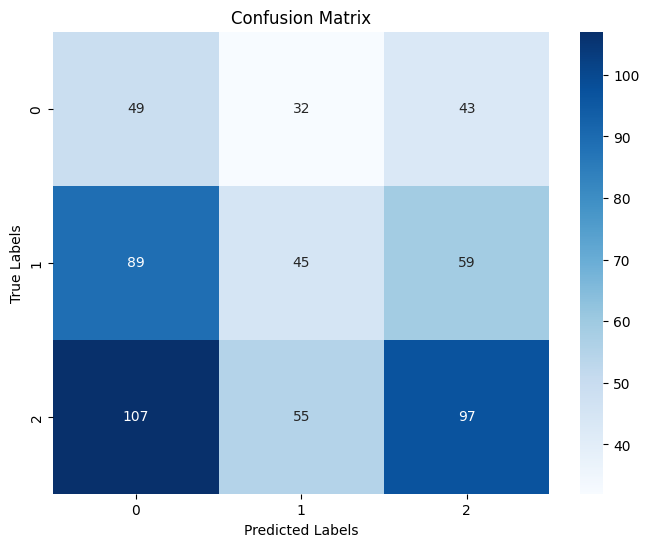


Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.40      0.27       124
           1       0.34      0.23      0.28       193
           2       0.49      0.37      0.42       259

    accuracy                           0.33       576
   macro avg       0.34      0.33      0.32       576
weighted avg       0.38      0.33      0.34       576



In [ ]:
y_true = validation_generator.classes
y_pred_probabilities = model_mb.predict(validation_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


# Resnet

In [ ]:
import os
import glob
import zipfile
import seaborn as sb
import numpy as np # linear algebra
import pandas as pd # data processing
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.metrics import confusion_matrix,classification_report
from keras.optimizers import Adam

In [ ]:
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = resnet.input

x = resnet.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x)

outputs = Dense(3, activation ='softmax')(x)

model_res50 = Model(inputs=inputs, outputs=outputs)

In [ ]:
layers = resnet.layers
for layer in layers:
    layer.trainable = False

model_res50.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_res = model_res50.fit_generator(
    training_generator,
    epochs= 10,
    validation_data = validation_generator,
    validation_steps = 8,
    steps_per_epoch = 10,
    class_weight=class_weights
    )

<ipython-input-9-0d203a821f1f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_res = model_res50.fit_generator(


Epoch 1/10
10/10 [==============================] - 288s 29s/step - loss: 1.6888 - accuracy: 0.3098 - val_loss: 1.2174 - val_accuracy: 0.2578
Epoch 2/10
10/10 [==============================] - 273s 30s/step - loss: 1.2717 - accuracy: 0.3769 - val_loss: 1.0945 - val_accuracy: 0.3340
Epoch 3/10
10/10 [==============================] - 257s 26s/step - loss: 1.2428 - accuracy: 0.3234 - val_loss: 1.0493 - val_accuracy: 0.4668
Epoch 4/10
10/10 [==============================] - 275s 29s/step - loss: 1.1625 - accuracy: 0.3528 - val_loss: 1.0694 - val_accuracy: 0.3926
Epoch 5/10
10/10 [==============================] - 287s 30s/step - loss: 1.1734 - accuracy: 0.3516 - val_loss: 1.1418 - val_accuracy: 0.2148
Epoch 6/10
10/10 [==============================] - 291s 30s/step - loss: 1.1657 - accuracy: 0.3625 - val_loss: 1.0820 - val_accuracy: 0.4609
Epoch 7/10
10/10 [==============================] - 273s 28s/step - loss: 1.1214 - accuracy: 0.3064 - val_loss: 1.0665 - val_accuracy: 0.3438
Epoch 

In [ ]:
model_res50.save('/content/drive/MyDrive/Neckline_Resnet50_classweight.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


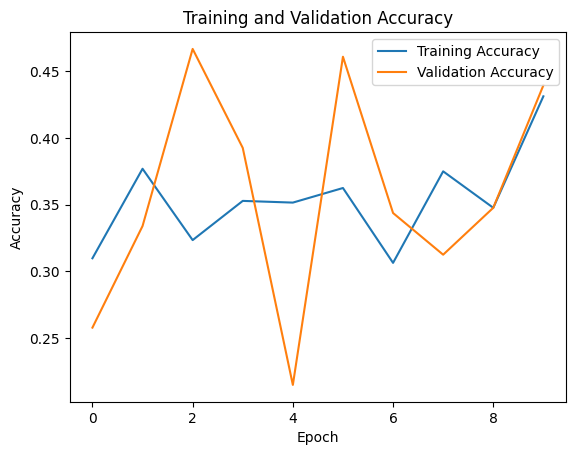

In [ ]:
plt.plot(history_res.history['accuracy'], label='Training Accuracy')
plt.plot(history_res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

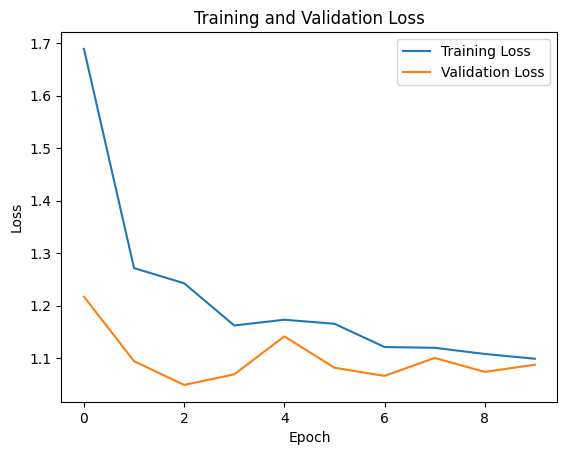

In [ ]:
plt.plot(history_res.history['loss'], label='Training Loss')
plt.plot(history_res.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 119s 13s/step


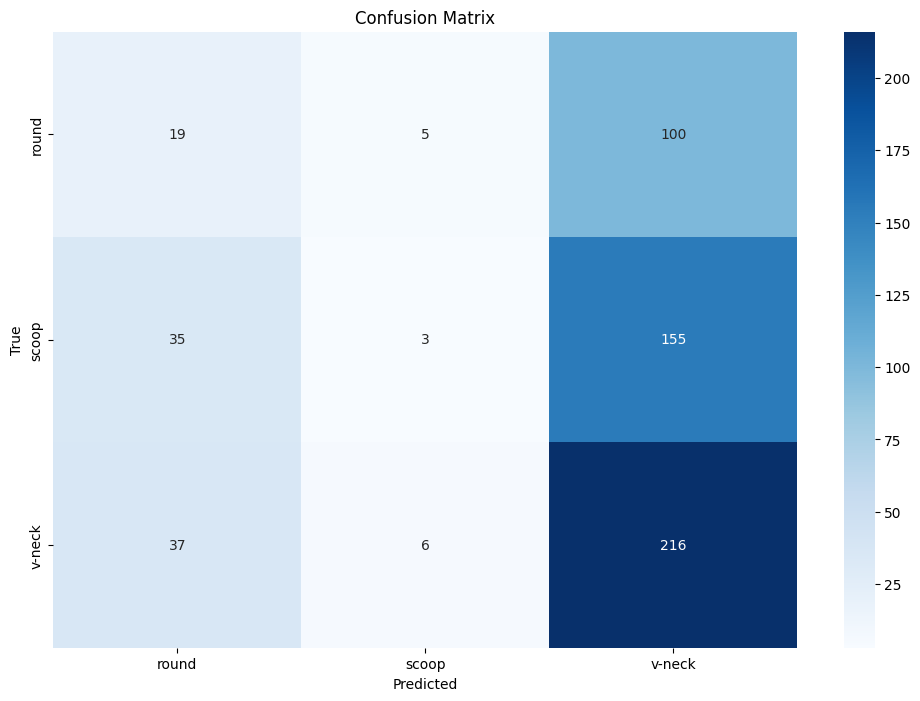

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_res = validation_generator.classes
y_pred_probabilities_res = model_res50.predict(validation_generator)
y_pred = y_pred_probabilities_res.argmax(axis=1)

cm_res = confusion_matrix(y_true_res, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_res, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
img_path2 = '/content/drive/MyDrive/15084221AE_11_f.jpg'
img = image.load_img(img_path2, target_size=(224, 224))
img_array2 = image.img_to_array(img)
img_array2 = np.expand_dims(img_array2, axis=0)

1/1 [==============================] - 0s 203ms/step
1: round - Probability: 0.31728994846343994
2: scoop - Probability: 0.6166832447052002
3: v-neck - Probability: 0.06602684408426285
Predicted Class: scoop
Probability: 0.6166832447052002


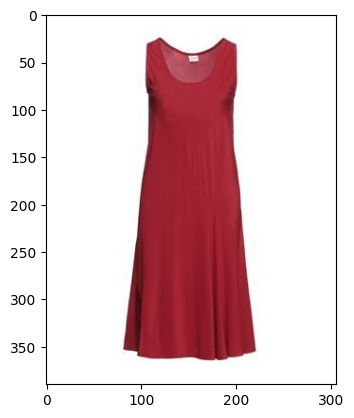

In [ ]:
image2 = cv2.imread(img_path2)
image_rgb2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb2)

predictions = model_res50.predict(img_array2)
for i in range(3):
    print(f"{i + 1}: {class_labels[i]} - Probability: {predictions[0][i]}")
max_class_index = np.argmax(predictions)
max_class_label = class_labels[max_class_index]
max_probability = predictions[0][max_class_index]
print(f"Predicted Class: {max_class_label}")
print(f"Probability: {max_probability}")